This Notebook we are performing human activity recognition by using a multiple sensor data approach such as accelerometer and gyroscope

Following are some of the features of Machine learning explored in this notebook
1. Time Series Classification of Sensor data using LSTM (Long Short Memory Neural Network)
2. Multi-Sensor Data Fusion Algorithm development using Transfer Learning. Parameters from Neural network from one-sensor   is transfer to the second sensor

Sensor Fusion Configuration 1: Transfer Learning Based Neural Network Development
As shown in image below, in the Sensor Fusion Configuration 2 We build LSTM1 for Gyroscope and train the model using only gyroscope data similarly we build a different model LSTM2 using only Accelerometer data

Final Model The Transfer learning based Fusion model is created by removing the Output layer of LSTM1 adding three more LSTM layers

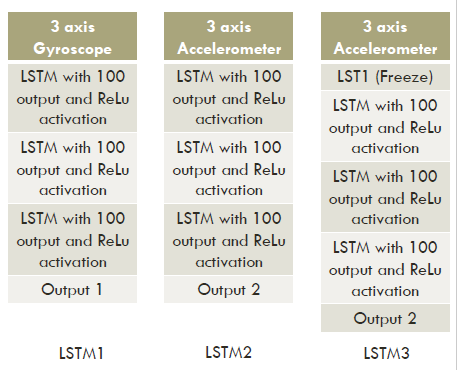

In [1]:
# add table of contents
# https://stackoverflow.com/questions/21151450/how-can-i-add-a-table-of-contents-to-a-jupyter-jupyterlab-notebook

In [2]:
# All Includes

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics
import os
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from matplotlib import pyplot
import matplotlib.pyplot as plt

In [3]:
#from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
import seaborn as sns
import pandas as pd

In [4]:
LABELS = [
    "WALKING","WALKING_UPSTAIRS","WALKING_DOWNSTAIRS","SITTING","STANDING","LAYING"
]

In [5]:
DATA_PATH = "data/"
DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"

In [6]:
# imports and helper functions to load and visualize data

directory_for_the_data=r"C:/Users/varun/OneDrive/Documents/Health_analytics_class/HA_hw_4/data/"

def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = dstack(loaded)
    return loaded

def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

def load_dataset_acc_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


def load_dataset_gyro_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'HAR Dataset/')
    print(trainX.shape, trainy.shape)
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'HAR Dataset/')
    print(testX.shape, testy.shape)
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print(trainX.shape, trainy.shape, testX.shape, testy.shape)
    return trainX, trainy, testX, testy


def load_acc_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_acc_group('train', prefix + 'HAR Dataset/')
    print(trainX.shape, trainy.shape)
    # load all test
    testX, testy = load_dataset_acc_group('test', prefix + 'HAR Dataset/')
    print(testX.shape, testy.shape)
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print(trainX.shape, trainy.shape, testX.shape, testy.shape)
    return trainX, trainy, testX, testy


def load_gyro_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_gyro_group('train', prefix + 'HAR Dataset/')
    print(trainX.shape, trainy.shape)
    # load all test
    testX, testy = load_dataset_gyro_group('test', prefix + 'HAR Dataset/')
    print(testX.shape, testy.shape)
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print(trainX.shape, trainy.shape, testX.shape, testy.shape)
    return trainX, trainy, testX, testy



def evaluate_model(trainX, trainy, testX, testy):
    verbose, batch_size = 0, 64
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    global history
    history=model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_data=(testX, testy))
    # Here I added a temp variable so that I can pull out the model
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy



def plot_train_and_val(mymodel):
  plt.plot(mymodel.history['accuracy'])
  plt.plot(mymodel.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()
  plt.plot(mymodel.history['loss'])
  plt.plot(mymodel.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()


In [7]:
def load_dataset_mobility_score(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'HAR Dataset/')
    print(trainX.shape, trainy.shape)
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'HAR Dataset/')
    print(testX.shape, testy.shape)
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    print(trainX.shape, trainy.shape, testX.shape, testy.shape)
    return trainX, trainy, testX, testy


In [8]:
trainX, trainy_non_categorical, testX, testy_non_categorical = load_dataset_mobility_score(prefix=directory_for_the_data)

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 1) (2947, 128, 9) (2947, 1)


In [9]:
import seaborn as sns

In [10]:
# useful new  gyro model
import keras
from keras.layers import Input, Dense , Concatenate
from keras.models import Model
# This returns a tensor
verbose = 0
trainX_gyro, trainy_gyro, testX_gyro, testy_gyro = load_gyro_dataset(prefix=directory_for_the_data)
n_timesteps, n_features, n_outputs = trainX_gyro.shape[1], trainX_gyro.shape[2], trainy_gyro.shape[1]

inputs  = Input(shape=(128,3))
# a layer instance is callable on a tensor, and returns a tensor
lstm_1 = LSTM(100,  activation='relu')(inputs)
Rvec =    keras.layers.RepeatVector(1)(lstm_1)
lstm_m_1 = LSTM(100, activation='relu', return_sequences=True)(Rvec)
lstm_m_2 = LSTM(100,  activation='relu', return_sequences=True)(lstm_m_1)
lstm_o_1= LSTM(100, activation='relu')(lstm_m_2)
lstm_o_2= LSTM(100, activation='relu')(lstm_m_2)
output1= Dense(6, activation="softmax")(lstm_o_1)

# This creates a model that includes # the Input layer and three Dense layers
gyro_model_n = Model(inputs=[inputs] , outputs=[output1])
print(gyro_model_n.summary())

m=256
gyro_model_n.compile(optimizer ='adam', loss =['categorical_crossentropy'], loss_weights = [1.0], metrics= ['accuracy'])
history_gyro_n = gyro_model_n.fit(trainX_gyro, trainy_gyro, epochs=30, batch_size=200 , validation_data=(testX_gyro, testy_gyro))

(7352, 128, 3) (7352, 1)
(2947, 128, 3) (2947, 1)
(7352, 128, 3) (7352, 6) (2947, 128, 3) (2947, 6)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 3)]          0         
                                                                 
 lstm (LSTM)                 (None, 100)               41600     
                                                                 
 repeat_vector (RepeatVector  (None, 1, 100)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 1, 100)            80400     
                                                                 
 lstm_2 (LSTM)               (None, 1, 100)            80400     
                                                                 
 lstm_3 (LSTM)             

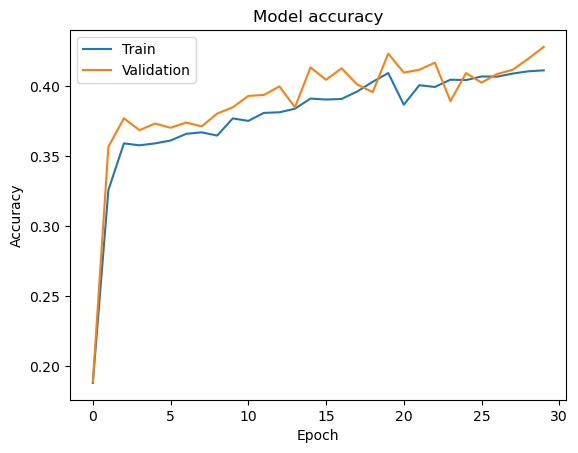

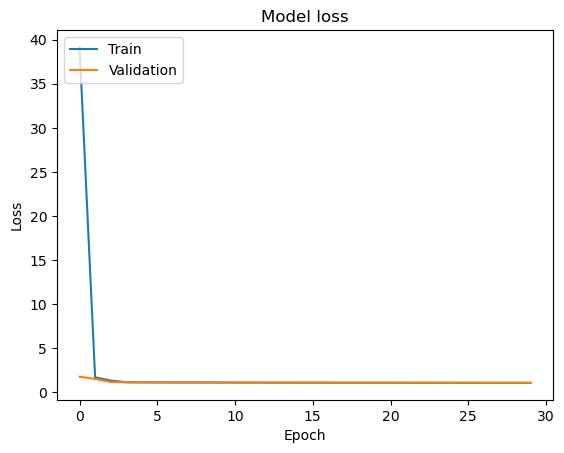

In [14]:
plot_train_and_val(history_gyro_n)

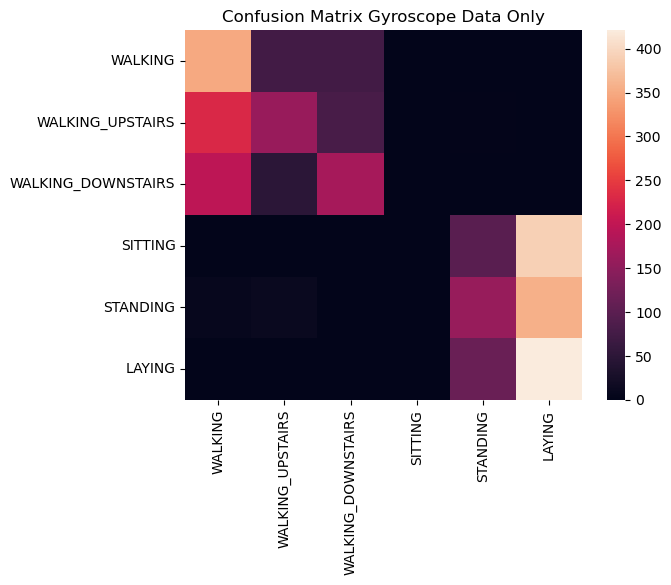

In [15]:
#from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = gyro_model_n.predict(testX_gyro)
true_class_id_test  = np.argmax(testy_gyro, axis=1)
predicted_class_ids = np.argmax(Y_pred,  axis=1)
cm = confusion_matrix(true_class_id_test,predicted_class_ids)
LABELS_plot = ["WALKING","WALKING_UPSTAIRS","WALKING_DOWNSTAIRS","SITTING","STANDING","LAYING"]


#https://seaborn.pydata.org/generated/seaborn.heatmap.html
ax_gyro = plt.axes()
sns.heatmap(cm, xticklabels=LABELS_plot, yticklabels=LABELS_plot, ax=ax_gyro)
ax_gyro.set_title('Confusion Matrix Gyroscope Data Only')
plt.show()


In [19]:
# model trainned using accelerometer data only
import keras
from keras.layers import Input, Dense , Concatenate
from keras.models import Model
# This returns a tensor
verbose = 0
trainX_acc, trainy_acc, testy_accX_acc, testy_accy = load_acc_dataset(prefix=directory_for_the_data)
n_timesteps, n_features, n_outputs = trainX_acc.shape[1], trainX_acc.shape[2], trainy_acc.shape[1]


inputs  = Input(shape=(128,6))
# a layer instance is callable on a tensor, and returns a tensor
lstm_1   = LSTM(100,  activation='relu')(inputs)
Rvec     = keras.layers.RepeatVector(1)(lstm_1)
lstm_m_1 = LSTM(100, activation='relu', return_sequences=True)(Rvec)
lstm_m_2 = LSTM(100,  activation='relu', return_sequences=True)(lstm_m_1)
lstm_o_1 = LSTM(100, activation='relu')(lstm_m_2)
lstm_o_2 = LSTM(100, activation='relu')(lstm_m_2)

output1= Dense(6, activation="softmax")(lstm_o_1)
acc_model_n = Model(inputs=[inputs] , outputs=[output1])
print(acc_model_n.summary())

m=256
acc_model_n.compile(optimizer ='adam', loss =['categorical_crossentropy'], loss_weights = [1.0], metrics= ['accuracy'])
history_acc = acc_model_n.fit(trainX_acc, trainy_acc, epochs=30, batch_size=200 , validation_data=(testy_accX_acc, testy_accy))


(7352, 128, 6) (7352, 1)
(2947, 128, 6) (2947, 1)
(7352, 128, 6) (7352, 6) (2947, 128, 6) (2947, 6)
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 6)]          0         
                                                                 
 lstm_10 (LSTM)              (None, 100)               42800     
                                                                 
 repeat_vector_2 (RepeatVect  (None, 1, 100)           0         
 or)                                                             
                                                                 
 lstm_11 (LSTM)              (None, 1, 100)            80400     
                                                                 
 lstm_12 (LSTM)              (None, 1, 100)            80400     
                                                                 
 lstm_13 (LSTM)          

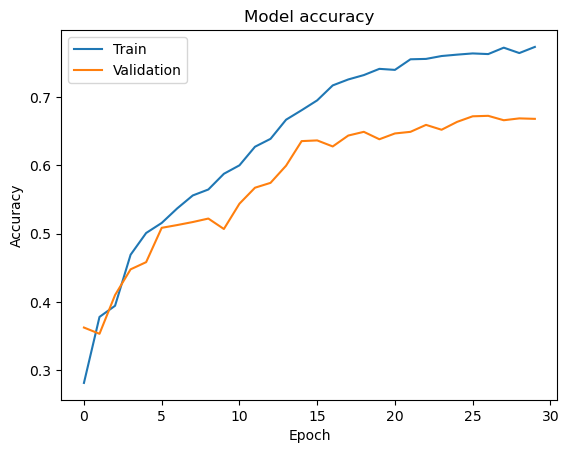

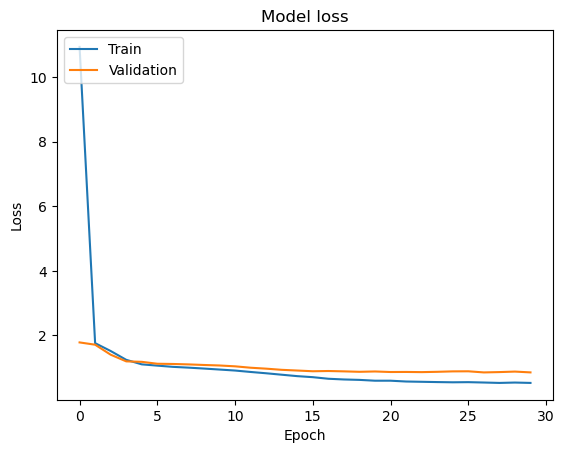

In [20]:
plot_train_and_val(history_acc)

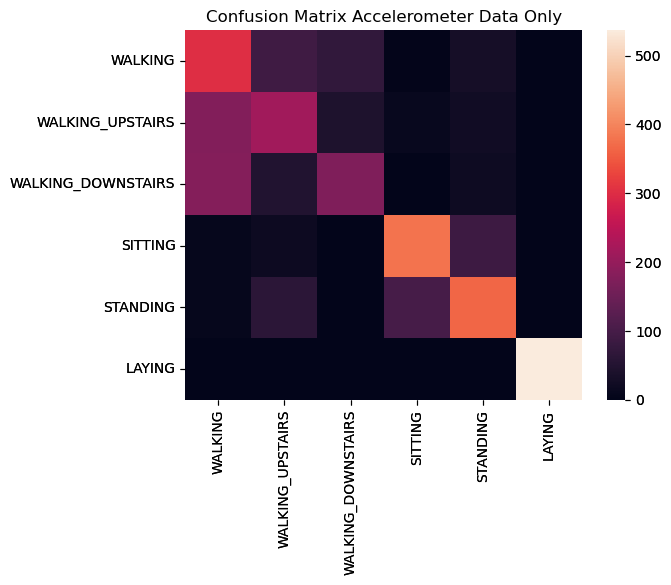

In [21]:
Y_pred = acc_model_n.predict(testy_accX_acc)
true_class_id_test  = np.argmax(testy_accy, axis=1)
predicted_class_ids = np.argmax(Y_pred,  axis=1)
cm = confusion_matrix(true_class_id_test,predicted_class_ids)
LABELS_plot = ["WALKING","WALKING_UPSTAIRS","WALKING_DOWNSTAIRS","SITTING","STANDING","LAYING"]
sns.heatmap(cm, xticklabels=LABELS_plot, yticklabels=LABELS_plot)
ax_accelerometer = plt.axes()
sns.heatmap(cm, xticklabels=LABELS_plot, yticklabels=LABELS_plot, ax=ax_accelerometer)
ax_accelerometer.set_title('Confusion Matrix Accelerometer Data Only')
plt.show()

In [36]:
# Transfer Learning Model 

import keras
from keras.layers import Input, Dense , Concatenate
from keras.layers import Dropout
from keras.models import Model

#freezing the layers of gyro model 
for layer_g in acc_model_n.layers[:6]:
    layer_g.trainable=False

verbose = 0
n_timesteps, n_features, n_outputs = trainX_acc.shape[1], trainX_acc.shape[2], trainX_acc.shape[1]

# adding the frozen of layers gyro model and using the frozen layers as an input to the new model
inputs   = acc_model_n.output
Rvec1    = keras.layers.RepeatVector(1)(inputs)
lstm_1   = LSTM(100,  activation='relu')(Rvec1)
Rvec     = keras.layers.RepeatVector(1)(lstm_1)
lstm_m_1 = LSTM(100, activation='relu', return_sequences=True)(Rvec)
lstm_m_2 = LSTM(100,  activation='relu', return_sequences=True)(lstm_m_1)
lstm_o_1 = LSTM(100, activation='relu')(lstm_m_2)
lstm_o_2 = LSTM(100, activation='relu')(lstm_m_2)

output1= Dense(6, activation="softmax")(lstm_o_1)
transfer_learning_model_n = Model(inputs=[acc_model_n.input] , outputs=[output1])
print(transfer_learning_model_n.summary())


transfer_learning_model_n.compile(optimizer ='adam', loss =['categorical_crossentropy'], metrics= ['accuracy'])
history_transfer_learning_model = transfer_learning_model_n.fit(trainX_acc, trainy_acc, epochs=30, batch_size=200 , validation_data=(testy_accX_acc, testy_accy))


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 6)]          0         
                                                                 
 lstm_10 (LSTM)              (None, 100)               42800     
                                                                 
 repeat_vector_2 (RepeatVect  (None, 1, 100)           0         
 or)                                                             
                                                                 
 lstm_11 (LSTM)              (None, 1, 100)            80400     
                                                                 
 lstm_12 (LSTM)              (None, 1, 100)            80400     
                                                                 
 lstm_13 (LSTM)              (None, 100)               80400     
                                                           

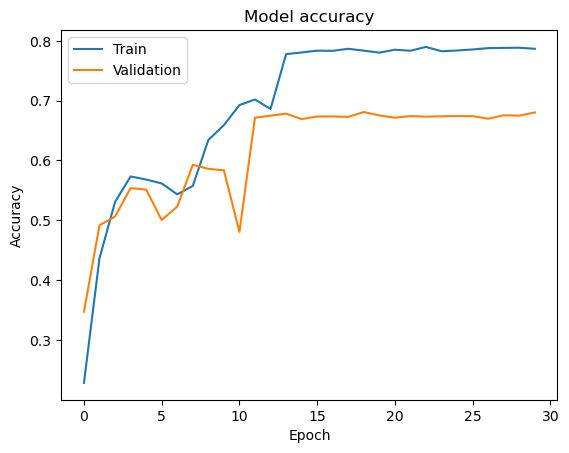

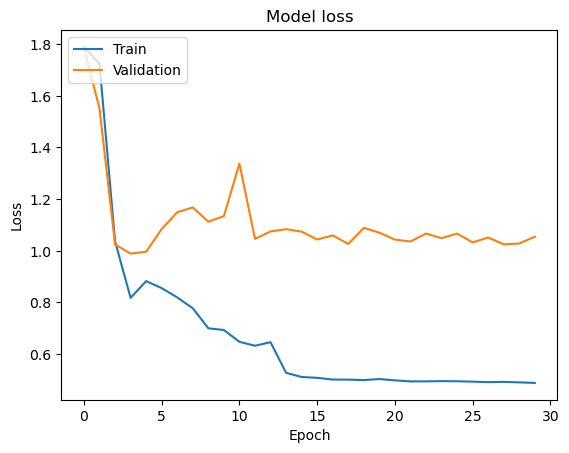

In [37]:
plot_train_and_val(history_transfer_learning_model)

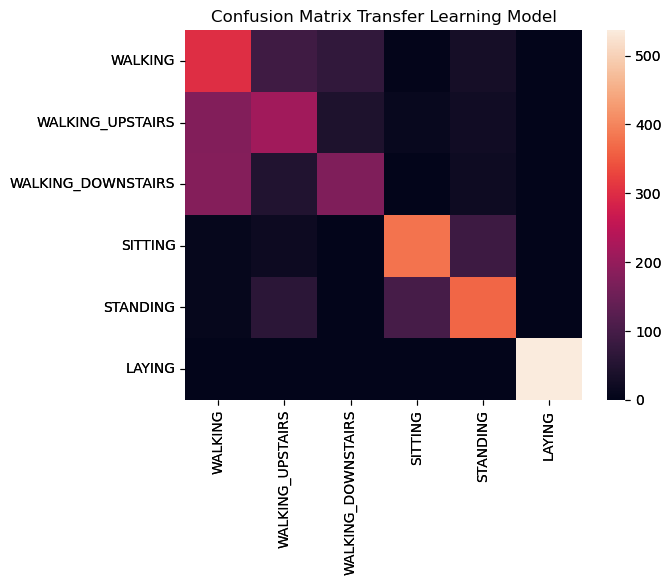

In [40]:
Y_pred = transfer_learning_model_n.predict(testy_accX_acc)
true_class_id_test  = np.argmax(testy_accy, axis=1)
predicted_class_ids = np.argmax(Y_pred,  axis=1)
LABELS_plot = ["WALKING","WALKING_UPSTAIRS","WALKING_DOWNSTAIRS","SITTING","STANDING","LAYING"]
sns.heatmap(cm, xticklabels=LABELS_plot, yticklabels=LABELS_plot)

ax_transfer_learning_model = plt.axes()
sns.heatmap(cm, xticklabels=LABELS_plot, yticklabels=LABELS_plot, ax=ax_transfer_learning_model)
ax_transfer_learning_model.set_title('Confusion Matrix Transfer Learning Model')
plt.show()
